In [95]:
%pip install pyyaml==6.0.1
%pip install 'git+https://github.com/facebookresearch/detectron2.git'
%pip install torch
%pip install torchvision
%pip install pycocotools>=2.0.7
%pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
%pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu121/torch2.2.1/index.html
%pip install opencv-python
%pip install tensorboard

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-2prnqope
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-2prnqope
  Resolved https://github.com/facebookresearch/detectron2.git to commit afe9eb920646102f7e6bf0cd2115841cea2aca13
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to 

In [124]:
import os
import json
import random
import cv2
import torch
from torch.utils.data import DataLoader, random_split
import numpy as np
import tensorboard
from matplotlib import pyplot as plt
from torch import __version__ as torch_ver
from detectron2 import __version__ as detectron_ver
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode
from detectron2.data import build_detection_test_loader

In [125]:
os.environ["TENSORBOARD_BINARY"] = "/home/devuser/.local/bin"

In [126]:
TORCH_VERSION = ".".join(torch_ver.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron_ver)

torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [127]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [128]:
%ls ./DATASET_BIG/

AGAR_id_list.md  dataset/  prompt.txt  training_lists/  visualize_colonies.py


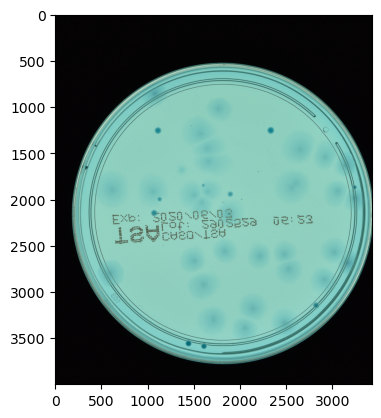

In [129]:
im = cv2.imread("./DATASET_BIG/dataset/6229.jpg")
plt.imshow(im)

In [130]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[04/02 23:19:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


The checkpoint state_dict contains keys that are not used by the model:
  roi_heads.mask_head.mask_fcn1.{bias, weight}
  roi_heads.mask_head.mask_fcn2.{bias, weight}
  roi_heads.mask_head.mask_fcn3.{bias, weight}
  roi_heads.mask_head.mask_fcn4.{bias, weight}
  roi_heads.mask_head.deconv.{bias, weight}
  roi_heads.mask_head.predictor.{bias, weight}


In [131]:
print("pred_boxes:", outputs["instances"].pred_boxes)
print("scores:", outputs["instances"].scores)
print("pred_classes:", outputs["instances"].pred_classes)

pred_boxes: Boxes(tensor([[ 161.2205,  466.9759, 3376.4070, 3807.3835]]))
scores: tensor([0.7892])
pred_classes: tensor([74])


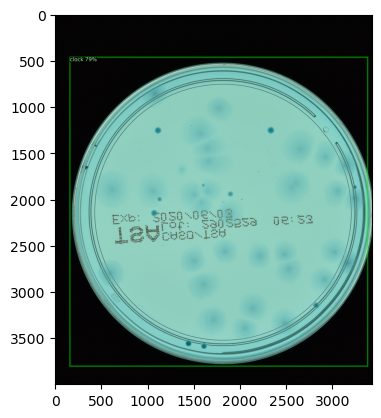

In [132]:
v = Visualizer(
    im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [133]:
agar_coco_dataset = load_coco_json(json_file="./DATASET_BIG/dataset/annotations.json",
                                   image_root="./DATASET_BIG/dataset/",
                                   dataset_name="agar_coco_dataset")

[04/02 23:19:28 d2.data.datasets.coco]: Loading ./DATASET_BIG/dataset/annotations.json takes 5.06 seconds.
[04/02 23:19:28 d2.data.datasets.coco]: Loaded 18000 images in COCO format from ./DATASET_BIG/dataset/annotations.json


In [134]:
# Например, возьмем 10% для тестовой выборки
test_size = int(0.10 * len(agar_coco_dataset))
train_val_size = len(agar_coco_dataset) - test_size

# Сначала делим датасет на обучающую и оставшуюся часть
train_val_dataset, test_dataset = random_split(
    agar_coco_dataset, [train_val_size, test_size])

# Теперь разделяем оставшуюся часть на обучающую и валидационную выборку
train_size = int(0.80 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(
    train_val_dataset, [train_size, val_size])

len(train_dataset.indices), len(val_dataset.indices), len(test_dataset.indices)

(12960, 3240, 1800)

In [135]:
type(train_dataset.indices), type(val_dataset.indices), type(test_dataset.indices)

(list, list, list)

In [138]:
for k, v in {"train": train_dataset, "test": test_dataset, "val": val_dataset}.items():
    try:
        DatasetCatalog.remove(f"agar_coco_dataset_{k}")
    except:
        pass
    DatasetCatalog.register(f"agar_coco_dataset_{k}", lambda _=k: v)

agar_coco_dataset_train_metadata = MetadataCatalog.get("agar_coco_dataset_train")
agar_coco_dataset_test_metadata = MetadataCatalog.get("agar_coco_dataset_test")
agar_coco_dataset_val_metadata = MetadataCatalog.get("agar_coco_dataset_val")

In [139]:
agar_coco_dataset_train_metadata, agar_coco_dataset_val_metadata, agar_coco_dataset_test_metadata

(namespace(name='agar_coco_dataset_train'),
 namespace(name='agar_coco_dataset_val',
           json_file='./output/agar_coco_dataset_val_coco_format.json'),
 namespace(name='agar_coco_dataset_test'))

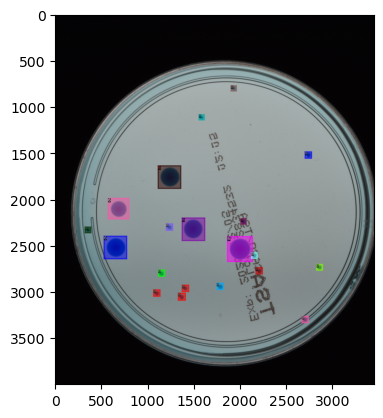

In [140]:
# To verify the dataset is in correct format,
# let's visualize the annotations of randomly selected samples in the training set
for d in random.sample(agar_coco_dataset, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],
                            metadata=agar_coco_dataset_train_metadata, scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

In [141]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("agar_coco_dataset_train",)
cfg.DATASETS.TEST = ("agar_coco_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
# This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = [] # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # под вопросом

In [142]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

print(f"Start training on {cfg.MODEL.DEVICE}")
trainer.train()

[04/02 23:20:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [119]:
%tensorboard --logdir ./output --bind_all

UsageError: Line magic function `%tensorboard` not found.


In [85]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.DATASETS.TEST = ("agar_coco_dataset_test",)
predictor = DefaultPredictor(cfg)

[04/02 23:06:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


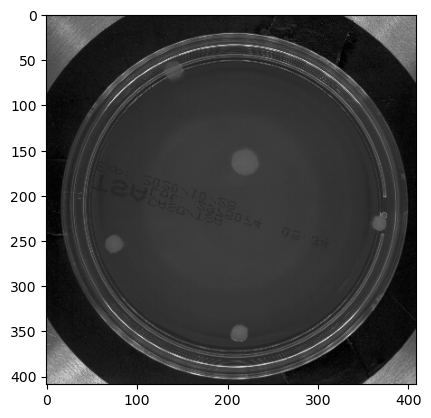

In [120]:
for d in random.sample(val_dataset.dataset.dataset, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=agar_coco_dataset_train_metadata,
                   scale=0.2,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

In [118]:
evaluator = COCOEvaluator("agar_coco_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "agar_coco_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

FileNotFoundError: [Errno 2] No such file or directory: './output/agar_coco_dataset_val_coco_format.json'